![MuJoCo banner](https://raw.githubusercontent.com/google-deepmind/mujoco/main/banner.png)







### Copyright notice

> <p><small><small>Copyright 2025 DeepMind Technologies Limited.</small></p>
> <p><small><small>Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at <a href="http://www.apache.org/licenses/LICENSE-2.0">http://www.apache.org/licenses/LICENSE-2.0</a>.</small></small></p>
> <p><small><small>Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.</small></small></p>

# Manipulation in The Playground!

In this notebook, we explore a custom manipulation task using the **UR3 Robot**. The objective is to train a policy for a **Pick and Place** task, where the robot must grasp a cube and transport it to a specific target zone, utilizing a shaped reward function to guide the learning process.

In [1]:
# @title Import MuJoCo, MJX, and Brax
from datetime import datetime
import functools
import os
from typing import Any, Dict, Sequence, Tuple, Union
from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.base import State as PipelineState
from brax.envs.base import Env, PipelineEnv, State
from brax.io import html, mjcf, model
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import networks as sac_networks
from brax.training.agents.sac import train as sac
from etils import epath
from flax import struct
from flax.training import orbax_utils
from IPython.display import HTML, clear_output
import jax
from jax import numpy as jp
from matplotlib import pyplot as plt
import mediapy as media
from ml_collections import config_dict
import mujoco
from mujoco import mjx, viewer
import numpy as np
from orbax import checkpoint as ocp

In [2]:
#@title Import The Playground

from mujoco_playground import wrapper
from mujoco_playground import registry

# Manipulation

MuJoCo Playground contains several manipulation environments (all listed below after running the command).

In [3]:
registry.manipulation.ALL_ENVS

('AlohaHandOver',
 'AlohaSinglePegInsertion',
 'PandaPickCube',
 'PandaPickCubeOrientation',
 'PandaPickCubeCartesian',
 'PandaOpenCabinet',
 'PandaRobotiqPushCube',
 'LeapCubeReorient',
 'LeapCubeRotateZAxis',
 'Ur3PickCube')

# Universal Robots Ur3

Picking up a cube with the UR3.

In [4]:
env_name = 'Ur3PickCube'
env = registry.load(env_name)
env_cfg = registry.get_default_config(env_name)

In [5]:
env_cfg

action_repeat: 1
action_scale: 0.04
ctrl_dt: 0.02
episode_length: 300
impl: jax
nconmax: 98304
njmax: 128
reward_config:
  scales:
    box_target: 25.0
    ctrl_norm: -0.01
    gripper_box: 3.0
    hoist_reward: 5.0
    is_lifted: 2.0
    joint_vel: -0.02
    no_floor_collision: 0.25
    robot_target_qpos: 0.1
    success_bonus: 10.0
sim_dt: 0.005

## Train Policy

Let's train the pick cube policy and visualize rollouts. The policy takes roughly 3 minutes to train on an RTX 4090.

In [6]:
from mujoco_playground.config import manipulation_params
ppo_params = manipulation_params.brax_ppo_config(env_name)
ppo_params

action_repeat: 1
batch_size: 512
discounting: 0.97
entropy_cost: 0.02
episode_length: 300
learning_rate: 0.001
network_factory:
  policy_hidden_layer_sizes: !!python/tuple
  - 32
  - 32
  - 32
  - 32
  policy_obs_key: state
  value_hidden_layer_sizes: !!python/tuple
  - 256
  - 256
  - 256
  - 256
  - 256
  value_obs_key: state
normalize_observations: true
num_envs: 2048
num_evals: 4
num_minibatches: 32
num_resets_per_eval: 10
num_timesteps: 25000000
num_updates_per_batch: 8
reward_scaling: 1.0
unroll_length: 10

### PPO

In [7]:
x_data, y_data, y_dataerr = [], [], []
times = [datetime.now()]


def progress(num_steps, metrics):
  clear_output(wait=True)

  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics["eval/episode_reward"])
  y_dataerr.append(metrics["eval/episode_reward_std"])

  plt.xlim([0, ppo_params["num_timesteps"] * 1.25])
  plt.xlabel("# environment steps")
  plt.ylabel("reward per episode")
  plt.title(f"y={y_data[-1]:.3f}")
  plt.errorbar(x_data, y_data, yerr=y_dataerr, color="blue")

  display(plt.gcf())

ppo_training_params = dict(ppo_params)
network_factory = ppo_networks.make_ppo_networks
if "network_factory" in ppo_params:
  del ppo_training_params["network_factory"]
  network_factory = functools.partial(
      ppo_networks.make_ppo_networks,
      **ppo_params.network_factory
  )

train_fn = functools.partial(
    ppo.train, **dict(ppo_training_params),
    network_factory=network_factory,
    progress_fn=progress,
    seed=1
)

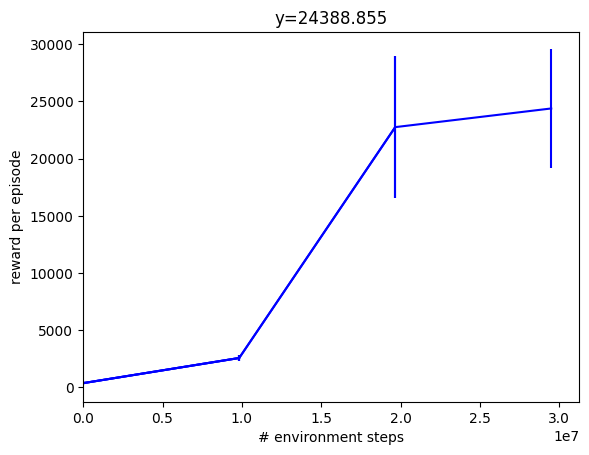

time to jit: 0:00:44.692420
time to train: 0:19:44.590909


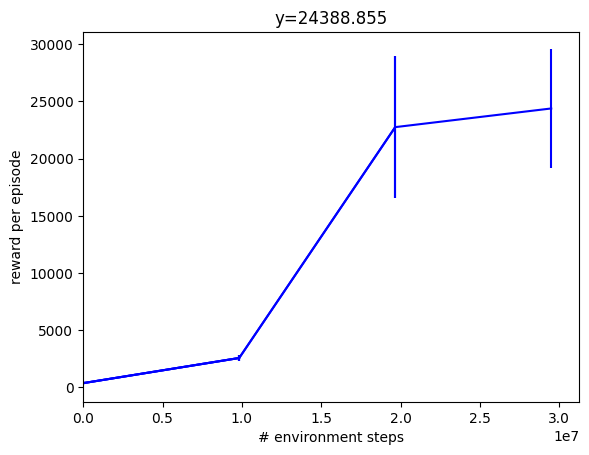

In [8]:
make_inference_fn, params, metrics = train_fn(
    environment=env,
    wrap_env_fn=wrapper.wrap_for_brax_training,
)
print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

## Visualize Rollouts

In [9]:
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)
jit_inference_fn = jax.jit(make_inference_fn(params, deterministic=True))

In [ ]:
rng = jax.random.PRNGKey(49)
rollout = []
n_episodes = 1

for _ in range(n_episodes):
  state = jit_reset(rng)
  rollout.append(state)
  for i in range(env_cfg.episode_length):
    act_rng, rng = jax.random.split(rng)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_step(state, ctrl)
    rollout.append(state)

render_every = 1
frames = env.render(rollout[::render_every], camera="cam0", height=480, width=640)
rewards = [s.reward for s in rollout]
media.show_video(frames, fps=1.0 / env.dt / render_every)

100%|██████████| 251/251 [00:06<00:00, 40.48it/s]


Saving Results

In [ ]:
# Define o nome do arquivo
caminho_arquivo = "ur3_pick_cube_policy_centered_zones.pkl"

# Salva os parâmetros no disco
model.save_params(caminho_arquivo, params)

print(f"Modelo salvo com sucesso em: {os.path.abspath(caminho_arquivo)}")

Modelo salvo com sucesso em: /home/thiag/projects/mujoco_playground/learning/notebooks/ur3_pick_cube_policy.pkl


In [ ]:
# Configurar o Ambiente e a Rede (Igual ao treino)
# É crucial que a configuração do ambiente seja A MESMA do treino
env = registry.load('Ur3PickCube') 

# Cria a função que constrói a estrutura da rede neural
network_factory = ppo_networks.make_ppo_networks

# Cria a função de inferência "vazia"
make_inference_fn = network_factory(
    env.observation_size,
    env.action_size,
    preprocess_observations_fn=wrapper.preprocess_observations_fn
)

# Carregar os Pesos do Arquivo
params = model.load_params("ur3_pick_cube_policy.pkl")

# Criar a função de inferência final com os pesos carregados
inference_fn = make_inference_fn(params)
jit_inference_fn = jax.jit(inference_fn)

print("Modelo carregado e pronto para o Viewer!")

#### Verificando política treinada em ambiente interativo (Não funcional ainda)

In [18]:
import time

In [19]:
env = registry.load('Ur3PickCube')
inference_fn = make_inference_fn(params)
jit_inference_fn = jax.jit(inference_fn)

# 2. Setup CPU Simulation
m = env.mj_model
d = mujoco.MjData(m)

print("Gerando estado inicial válido (Zonas e Keyframe)...")
rng = jax.random.PRNGKey(0)
# Rodamos o reset na GPU para calcular as posições corretas e levantar o robô
state = jit_reset(rng)

# Copiamos o estado da GPU (que tem o robô em pé e as caixas certas) para a CPU (d)
mjx.get_data_into(d, m, state.data)


# Atualiza a física na CPU para garantir que colisões e sensores estejam sincronizados
mujoco.mj_forward(m, d)

# 3. Launch Viewer
print("Launching Viewer...")
print("Double-click the Red Cube to move it.")

# Inicializa o contador fora do loop
i = 0

with mujoco.viewer.launch_passive(m, d) as viewer:
    rng = jax.random.PRNGKey(0)

    while viewer.is_running():
        step_start = time.time()

        # A. Input: Sync CPU (Viewer) -> GPU (Policy)
        mjx_data = mjx.put_data(m, d)

        # Pega a posição do alvo (Mocap)
        target_pos = mjx_data.mocap_pos[env._mocap_target].ravel()
        # Pega a posição da caixa (Body)
        box_position = mjx_data.xpos[env._obj_body]

        # --- DEBUG VISUAL ---
        # Agora que temos as variáveis, podemos calcular a distância
        dist = np.linalg.norm(box_position - target_pos)

        if i % 60 == 0: # Aprox. a cada 1 segundo (se rodar a 60fps)
            print(f"Distância: {dist:.3f} | Target Pos: {target_pos}")
        
        # B. Observation
        info = {"target_pos": target_pos}
        obs = env._get_obs(mjx_data, info)

        # C. Inference
        rng, key = jax.random.split(rng)
        action, _ = jit_inference_fn(obs, key)

        # D. Act: Apply action to CPU simulation
        d.ctrl[:] = np.array(action)

        # E. Step Physics (on CPU)
        for _ in range(env.n_substeps):
            mujoco.mj_step(m, d)

        # F. Output: Sync Physics -> Viewer
        viewer.sync()

        i += 1

        # Sleep to maintain real-time speed
        time_until_next_step = m.opt.timestep - (time.time() - step_start)
        if time_until_next_step > 0:
            time.sleep(time_until_next_step)

Gerando estado inicial válido (Zonas e Keyframe)...
Launching Viewer...
Double-click the Red Cube to move it.
Distância: 0.687 | Target Pos: [ 0.47370613 -0.3514642   0.26223904]
Distância: 0.678 | Target Pos: [ 0.47370613 -0.3514642   0.26223904]
Distância: 0.678 | Target Pos: [ 0.47370613 -0.3514642   0.26223904]
